In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *
from graph_format import *

# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim


In [2]:
_, _, moments = prepare_data(par)

In [3]:
means_string = "Data ny def/mean_matrix.csv"
covariance_string = "Data ny def/variance_matrix.csv"

variables = ["extensive_v2", "formue_plsats", "yearly_hours"]

mean, variance_diag = load_and_process_data(means_string, covariance_string, par, variables)

variance_cut = np.concatenate([
    variance_diag[:40],
    variance_diag[55:55+70],
    variance_diag[55+70:55+70+40]
])

diag_inv = 1 / variance_cut
weight = np.diag(diag_inv)

In [4]:
# def randomize_theta_init(theta_init, bounds, pct=0.05):
#     randomized = []
#     for val, (lower, upper) in zip(theta_init, bounds):
#         delta = pct * val
#         min_val = max(lower, val - delta)
#         max_val = min(upper, val + delta)
#         randomized_val = np.random.uniform(min_val, max_val)
#         randomized.append(randomized_val)
#     return np.array(randomized)

# # Prepare SMM
# theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "gamma_1")

# theta_init = np.array([0.9589428895, 1.1563051504, 2.2653520802, 6.8645167115, 6.8653298986, 0.0000259474])

# # Original bounds
# orig_bounds = [(0.0, 1.0),   # beta
#                (0.1, 6.0),   # sigma
#                (0.1, 10.0),  # gamma
#                (0.0, 20.0),  # mu
#                (0.0, 15.0),  # zeta
#                (0.0, 0.0001)
#                ] 

# theta_init_scaled = scale_params(theta_init, orig_bounds)

# theta_random = randomize_theta_init(theta_init, orig_bounds)
# theta_random_scaled = scale_params(theta_random, orig_bounds)

# # Do SMM
# objective = lambda theta: obj_func(theta, theta_names, mean, weight, model, orig_bounds, do_print=True)

# res = minimize(
#     objective, 
#     theta_init_scaled,
#     method='nelder-mead',
#     bounds=[(0,1)] * len(theta_init_scaled),
#     tol=1e-6,
#     options={"maxiter":2000}
# )

# theta_final = unscale_params(res.x, orig_bounds)

# print(theta_final)

In [ ]:
import numpy as np
from scipy.optimize import dual_annealing

def randomize_theta_init(theta_init, bounds, pct=0.05):
    randomized = []
    for val, (lower, upper) in zip(theta_init, bounds):
        delta = pct * val
        min_val = max(lower, val - delta)
        max_val = min(upper, val + delta)
        randomized_val = np.random.uniform(min_val, max_val)
        randomized.append(randomized_val)
    return np.array(randomized)

# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "gamma_1")

theta_init = np.array([0.9589428895, 1.1563051504, 2.2653520802, 6.8645167115, 6.8653298986, 0.0000259474])

orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 20.0),  # mu
               (0.0, 15.0),  # zeta
               (0.0, 0.0001) # gamma_1
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)
theta_random = randomize_theta_init(theta_init, orig_bounds)
theta_random_scaled = scale_params(theta_random, orig_bounds)

objective = lambda theta: obj_func(theta, theta_names, mean, weight, model, orig_bounds, do_print=True)

res = dual_annealing(
    objective,
    bounds=[(0, 1)] * len(theta_init_scaled),
    maxiter=1000,
    initial_temp=5230.0,
    visit=2.62,
    accept=-5.0,
    seed=42
)

theta_final = unscale_params(res.x, orig_bounds)
print(theta_final)


0.3745401188, 5.7092144078, 7.3467400239, 11.9731696839, 2.3402796066, 0.0000155995, 


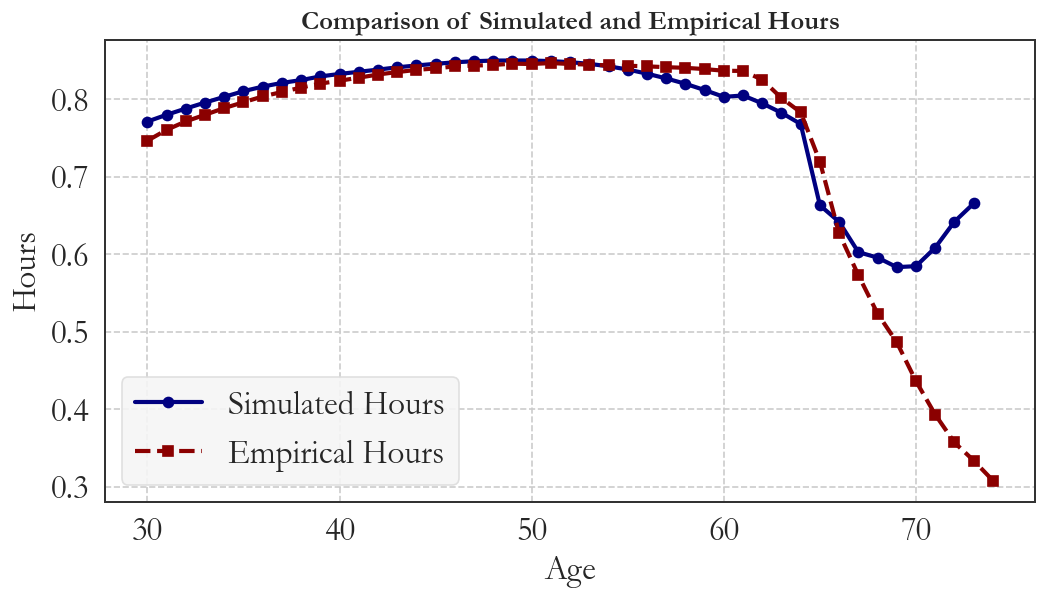

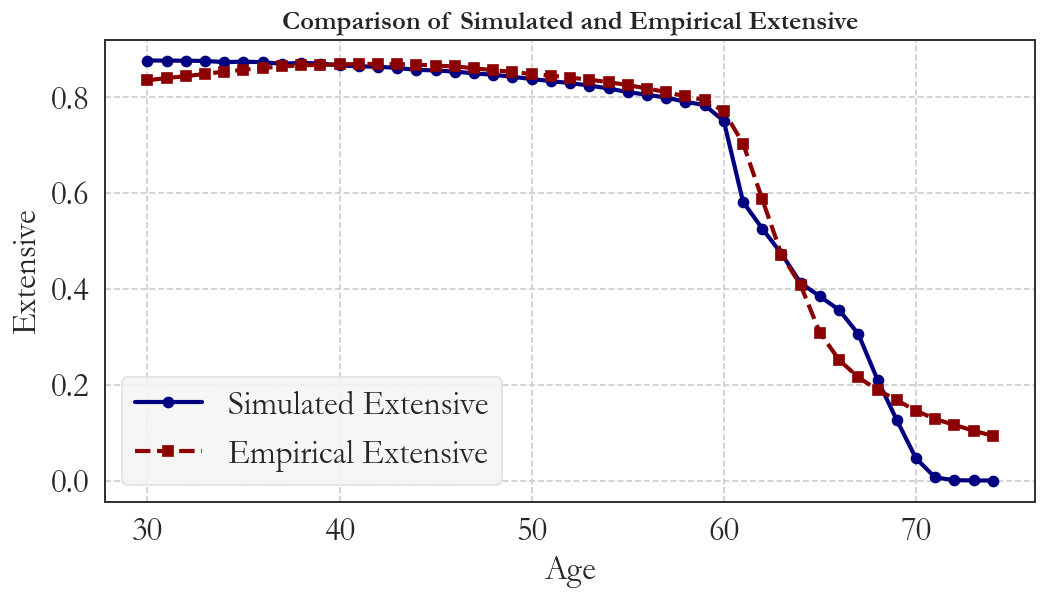

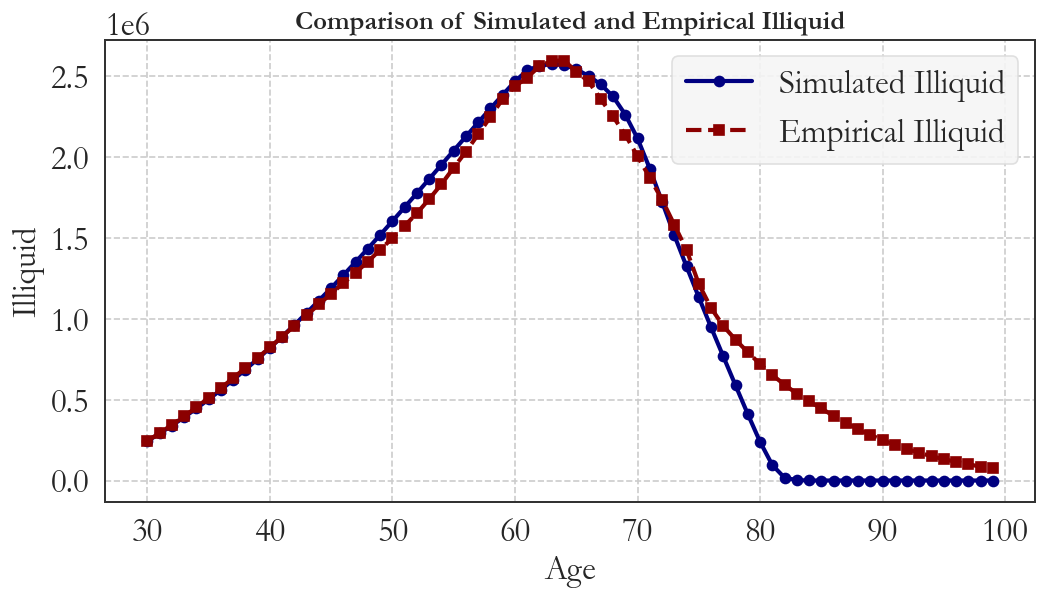

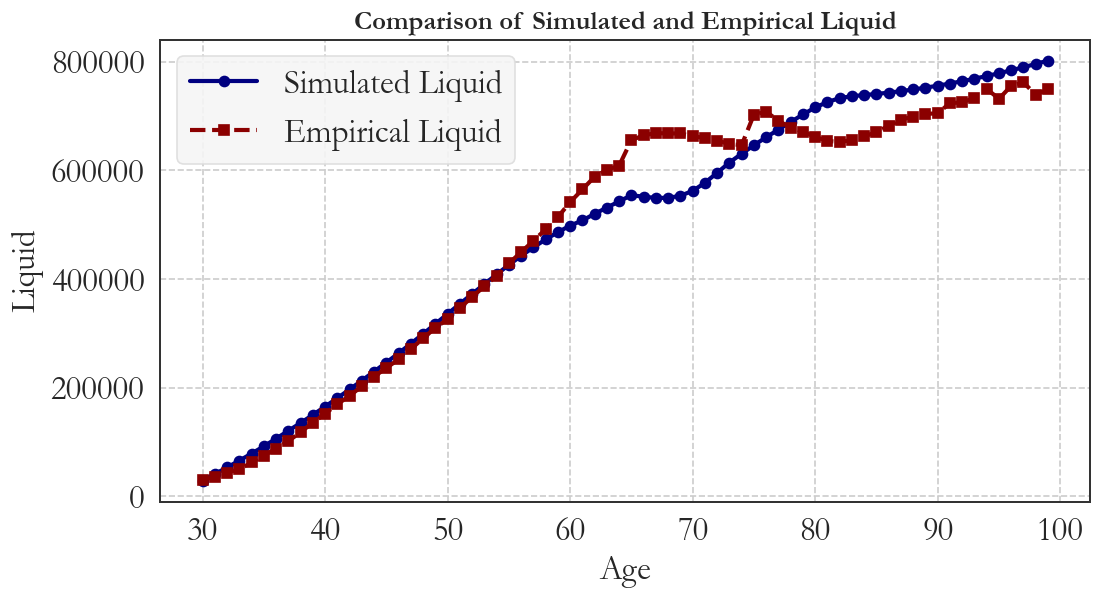

In [ ]:
# # Load the model with calibrated values
# theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "gamma_1")
# # # theta_names = ("beta", "zeta")

# # theta_final = unscale_params(res.x, orig_bounds)

# # theta_final = np.array([0.9589428895, 1.1563051504, 2.2653520802, 6.8645167115, 6.8653298986, 0.0000259474])

# # for i, name in enumerate(theta_names):
# #     setattr(model.par, name, theta_final[i])

# model.solve()
# model.simulate()

# # plot the graph with calibrated values 
# a_dict = {
#     'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:45], moments['hours']],
#     'extensive': [np.mean(model.sim.ex, axis=0)[:45], moments['extensive']],
#     'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
#     'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
# }

# # Define colors
# simulated_color = "navy"  # Dark blue
# empirical_color = "darkred"  # Dark red
# ci_color = "lightcoral"  # Light red for confidence bands

# for key, (simulated, empirical) in a_dict.items():
#     plt.figure(figsize=(10, 5))
    
#     x_vals = np.arange(len(empirical)) + par.start_age
    
#     plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
#     plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

#     # # 99.9% confidence interval
#     # ci = std_dev
#     # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

#     plt.xlabel("Age")
#     plt.ylabel(key.capitalize())
#     plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [7]:
# prepare your data dict
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:55],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:55],
                  moments['extensive']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}


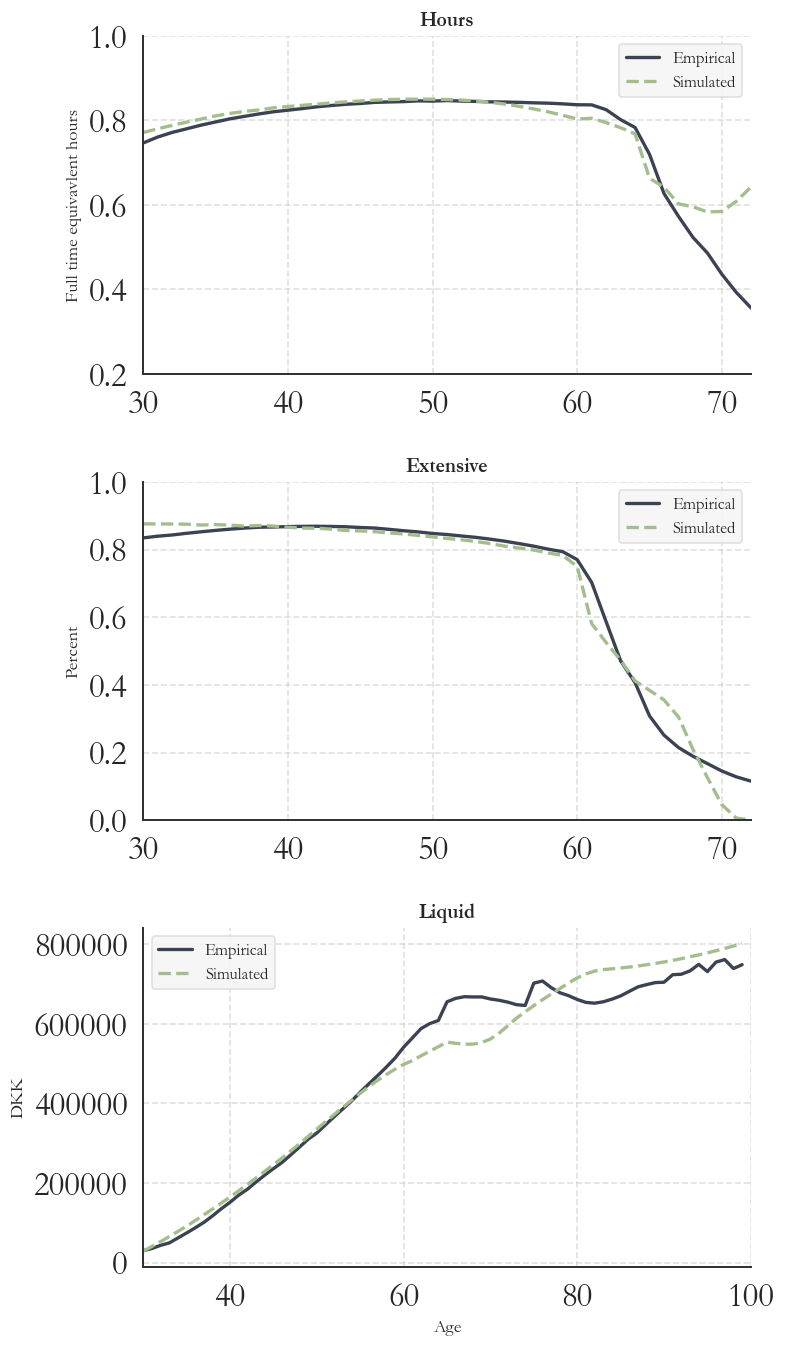

In [8]:
plot_model_vs_data_grid(a_dict, title="", save_title="in_sample_fit.png")


In [9]:
means_data = pd.read_csv("Data/mean_matrix.csv")

b_dict = {
    'illiquid': [np.clip(np.clip(np.mean(model.sim.s, axis=0), 0, None) / 1_000_000, 0, None),
                 moments['savings'] / 1_000_000]  ,
    'wages':    [np.nanmean(np.where(model.sim.ex==1, model.sim.w, np.nan)[:, :31] , axis=0),
                 means_data[means_data["alder"] <= 60]["hourly_salary_plsats_Mean"].to_numpy() * 1924]
        }

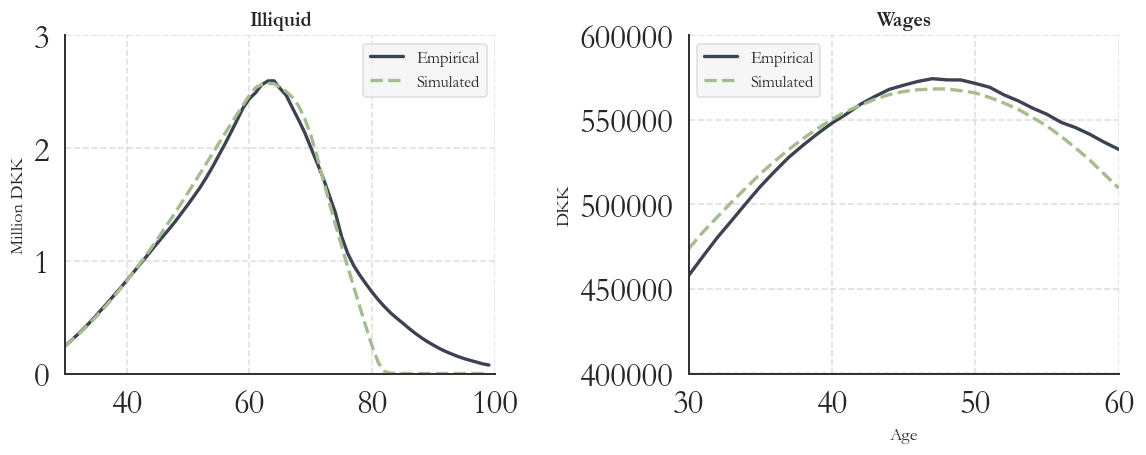

In [10]:
plot_model_vs_data_grid_oos(b_dict, title="", save_title="out_of_sample_fit.png")


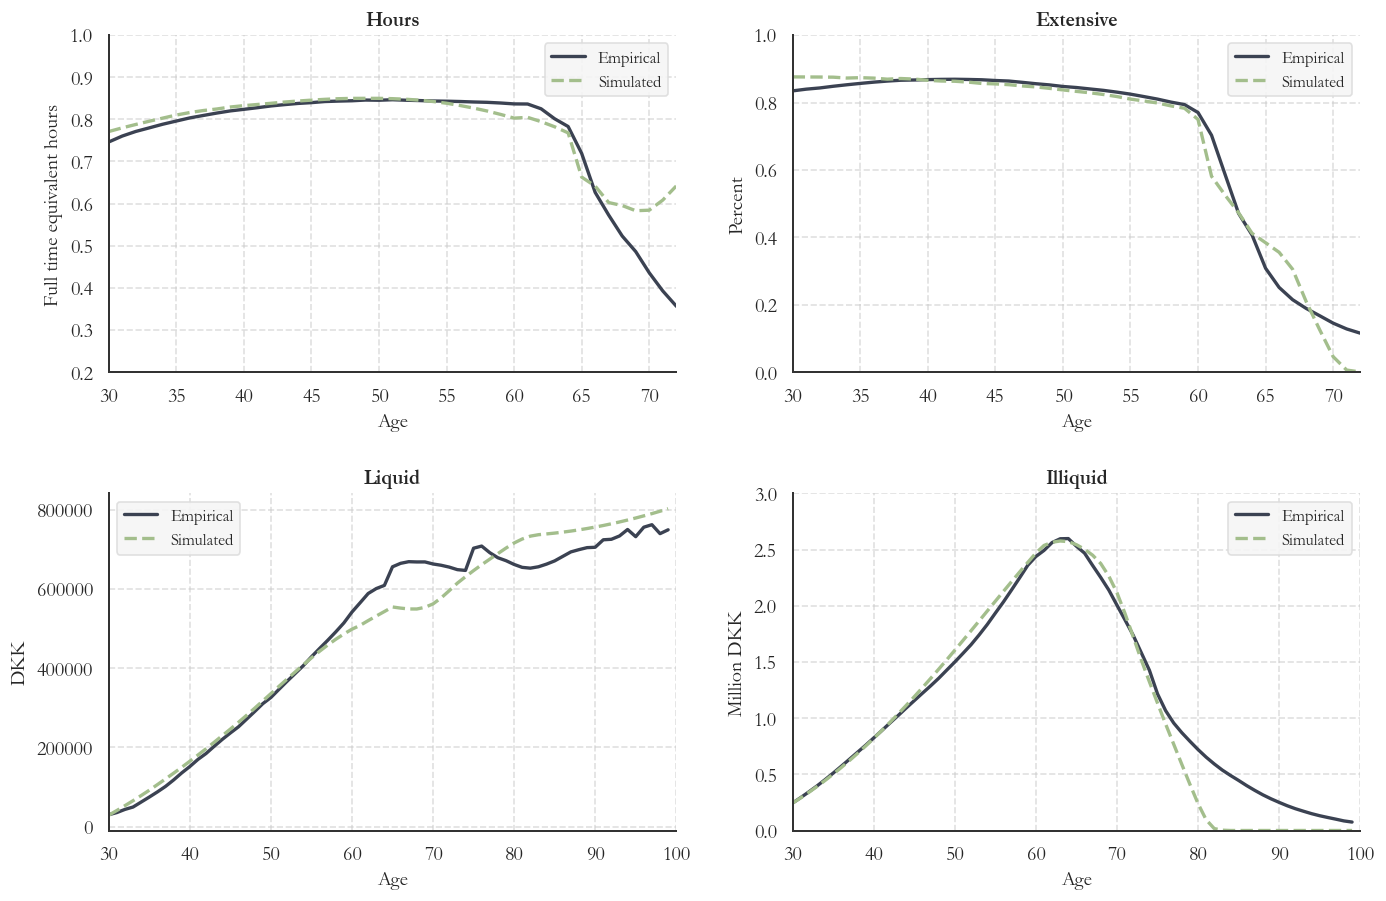

In [15]:
a_dict_new = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:43],
            moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:43],
                  moments['extensive']],
    'liquid': [np.mean(model.sim.a, axis=0),
            moments['assets']],
    'illiquid': [np.clip(np.clip(np.mean(model.sim.s, axis=0), 0, None) / 1_000_000, 0, None),
            moments['savings'] / 1_000_000]  ,
}


plot_model_vs_data_2x3(a_dict_new, title=None, save_title="2018_all_graph_slides")

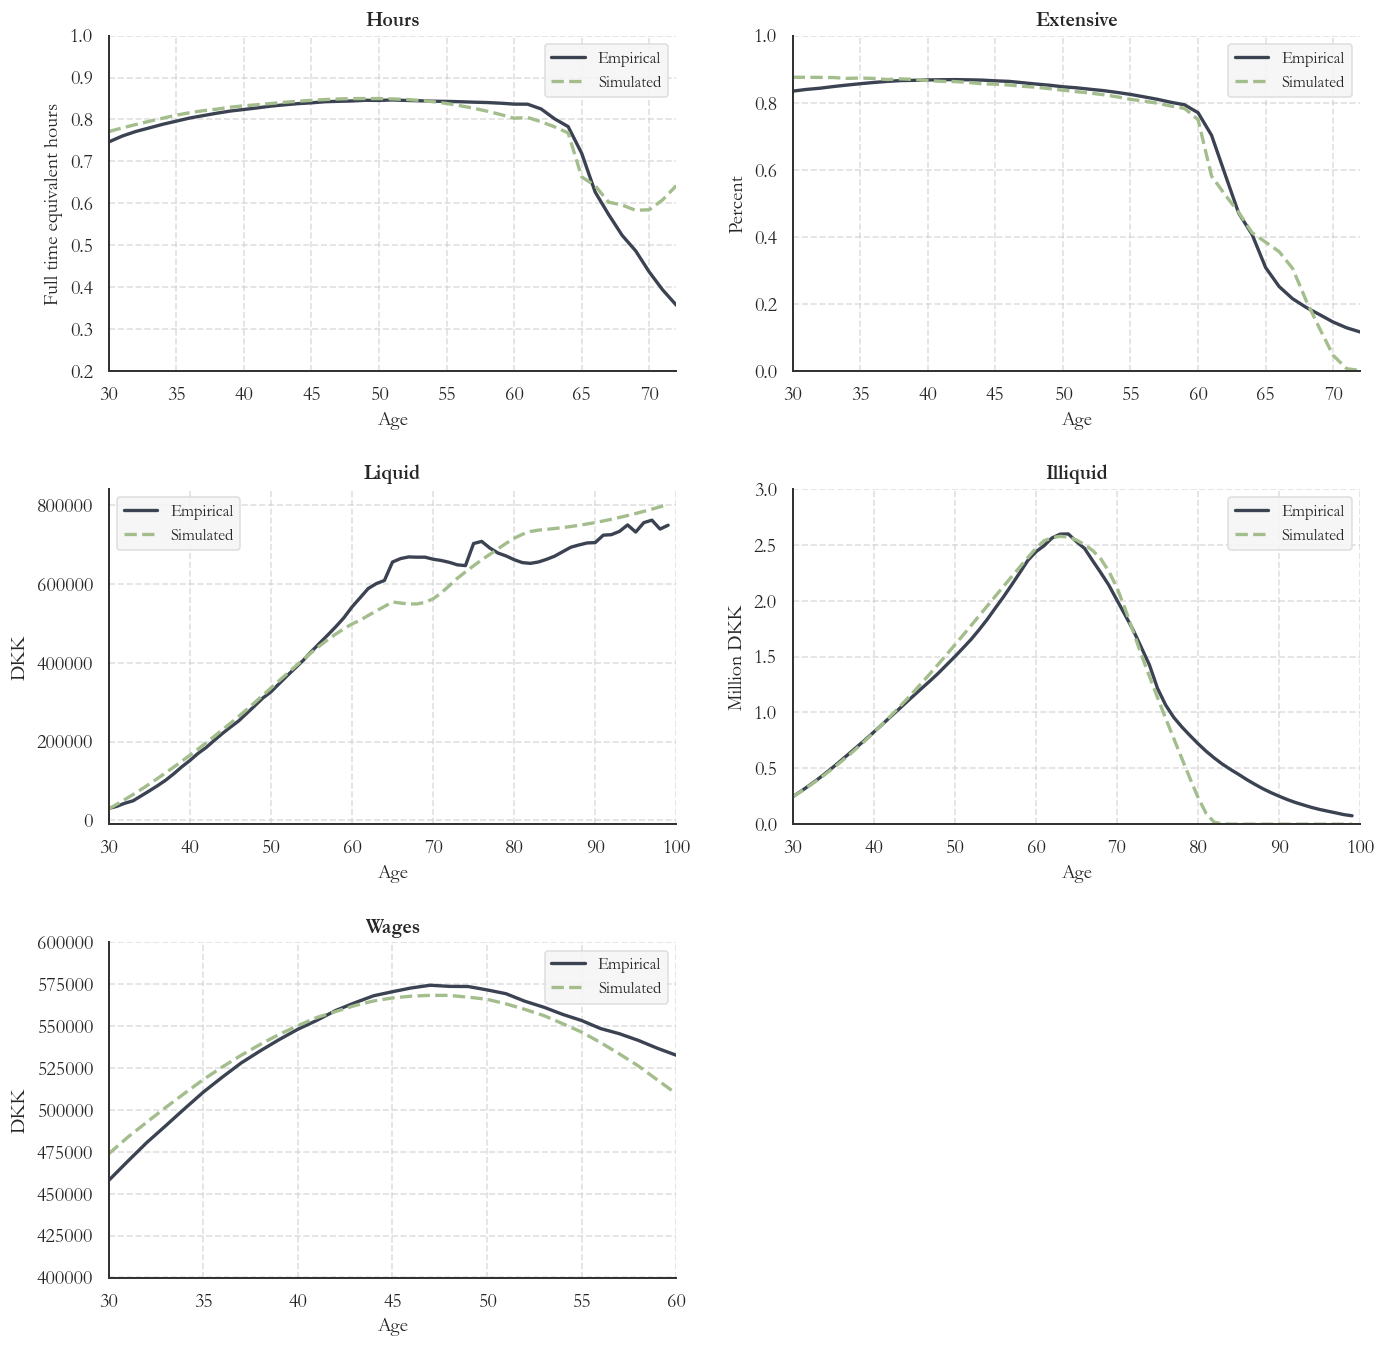

In [12]:
plot_model_vs_data_3x2(a_dict_new, title=None, save_title="oos_all_graph")

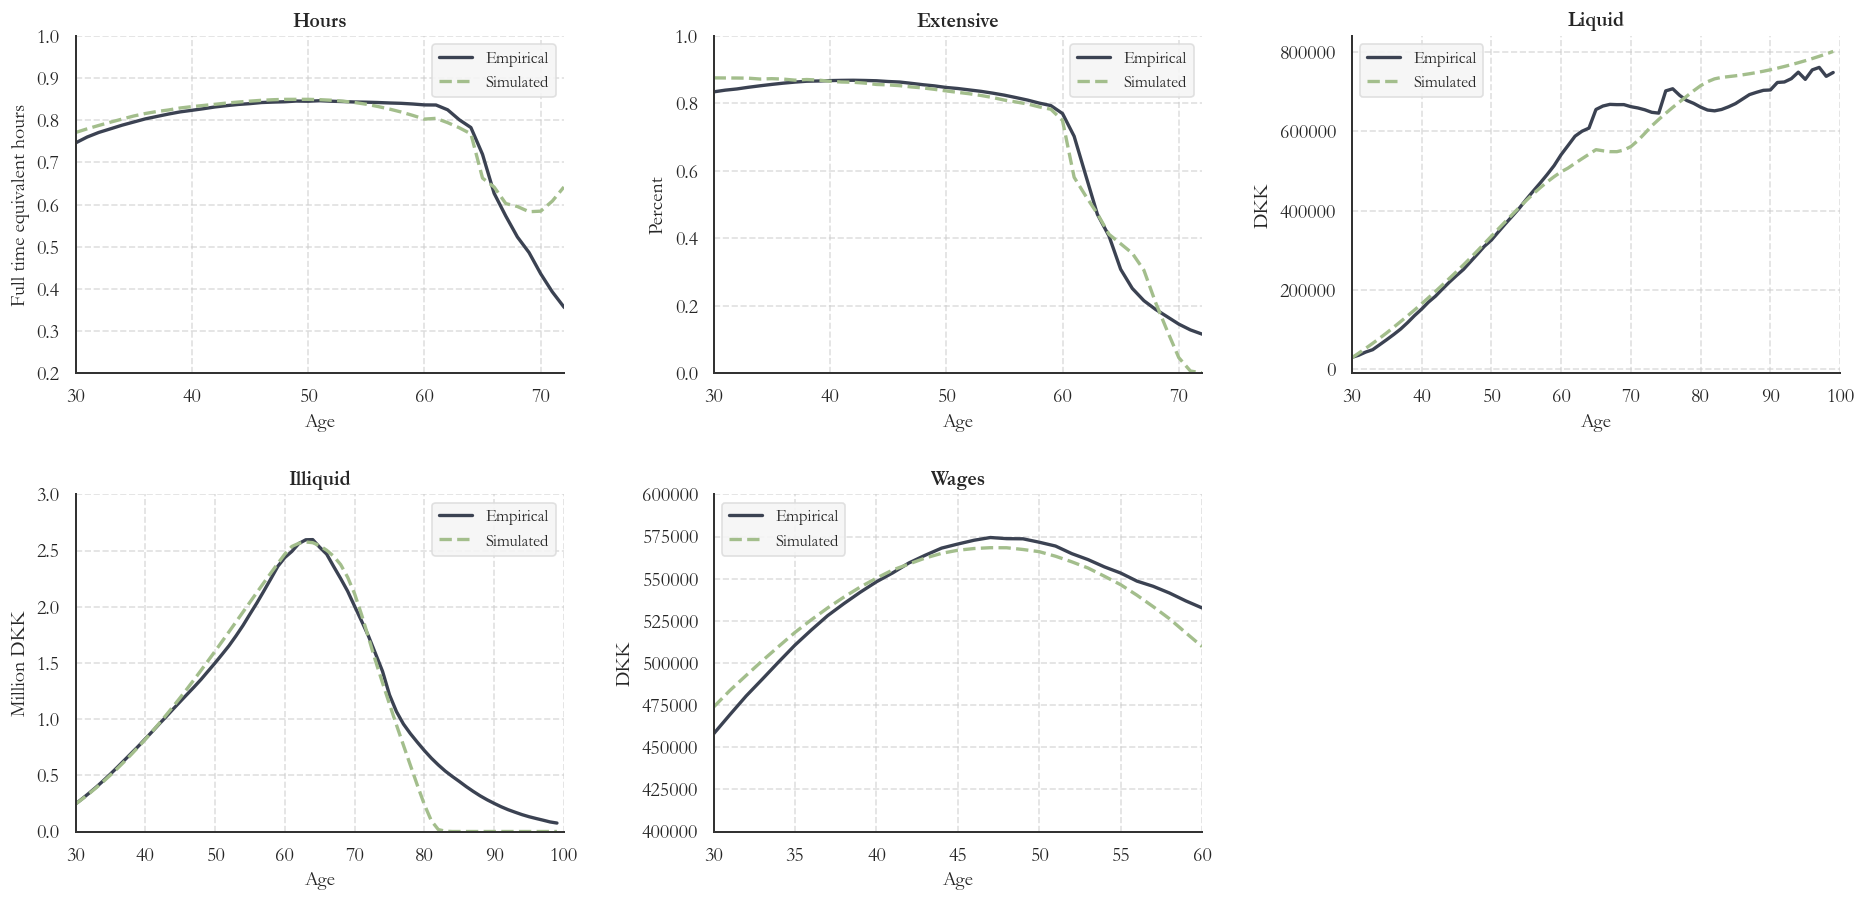

In [13]:


plot_model_vs_data_2x3(a_dict_new, title=None, save_title="oos_all_graph")